# 0. Imports and loadings

In [139]:
import matplotlib.pyplot as plt
import math
import random as rd
import numpy as np
import matplotlib.ticker as mticker
from scipy import signal
from scipy.io import wavfile
import os





In [140]:
train_database_path = '/teamspace/studios/this_studio/Données/FordB_TRAIN.txt'
test_database_path = '/teamspace/studios/this_studio/Données/FordB_TEST.txt'
sampling_frequency = 40000

## Database loadings

In [141]:
class Data():
    def __init__(self, index, values, database_name = ''):
        self.index = index
        self.database_name = database_name

        #Forbidden info in the context of the project
        #self.class_index = values[0]

        self.values = values[1:]

In [142]:
class Database():
    def __init__(self, name, datas):
        self.name = name
        self.datas = datas

        for data in self.datas:
            data.database_name = self.name

In [143]:
def load_database(database_path):
    datas = []

    with open(database_path, 'r') as file:
        data_index = 0
        for raw_data in file:
            raw_data_line = raw_data.strip('\n').split(' ')
            data_values = []
            for raw_value in raw_data_line:
                if len(raw_value)!=0:
                    data_values.append(float(raw_value))

            datas.append(Data(data_index, data_values))
            data_index += 1
        
    name = database_path.strip('.txt').split('/')[-1]
    return Database(name, datas)



In [144]:
train_database = load_database(train_database_path)
test_database = load_database(test_database_path)

for database in [train_database, test_database]:    
    print(f'\n\nNumber of datas in {database.name} : {len(database.datas)}')



Number of datas in FordB_TRAIN : 3636


Number of datas in FordB_TEST : 810


# 1. Pre-analysis with plot visualisation

## 1.0 Sampling

The pre-analysis consist of intuitive visualisation of some plots of some data to get an idea of what is happening. Since the pre-analysis is "hand-made", only some sample of the database are considered. The sample are randomly selected but they are kept throughout all of this part.

In [145]:
sample_size = 12
train_sample = rd.sample(train_database.datas, sample_size)
test_sample = rd.sample(test_database.datas, sample_size)


## 1.1 Signal plots

### 1.1.0 Codes and variables

In [146]:
def plot_datas(datas, truncation_start_index = 0, truncation_stop_index = -1, sampling_frequency = 1):
    # Calculate number of rows and columns (can be square or based on your preference)
    cols = math.ceil(math.sqrt(len(datas)))  # Try to make the figure roughly square
    rows = math.ceil(len(datas) / cols)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    # Flatten the axes array for easy iteration (only if more than 1 row/column)
    axes = axes.flatten()

    # Now plot something on each subplot
    for  i, data in enumerate(datas):
        
        time = [i/sampling_frequency for i in range(len(data.values[truncation_start_index : truncation_stop_index]))]

        axes[i].plot(time, data.values[truncation_start_index : truncation_stop_index])  
        
        title = f'{data.database_name} - {data.index}'
        if truncation_start_index != 0 or truncation_stop_index != -1:
            if truncation_stop_index == -1:
                truncation_stop_index = len(data.values)
            title += f' - truncated to [{truncation_start_index} ; {truncation_stop_index}]' 

        axes[i].set_title(title)
        axes[i].set_xlabel("Time (s)")
        axes[i].set_ylabel("Amplitude (unknown unit)")


    # Hide unused subplots if any
    for i in range(len(datas), rows * cols):
        fig.delaxes(axes[i])  # Deletes the extra subplots

    plt.tight_layout()
    plt.show()

### 1.1.1 Train

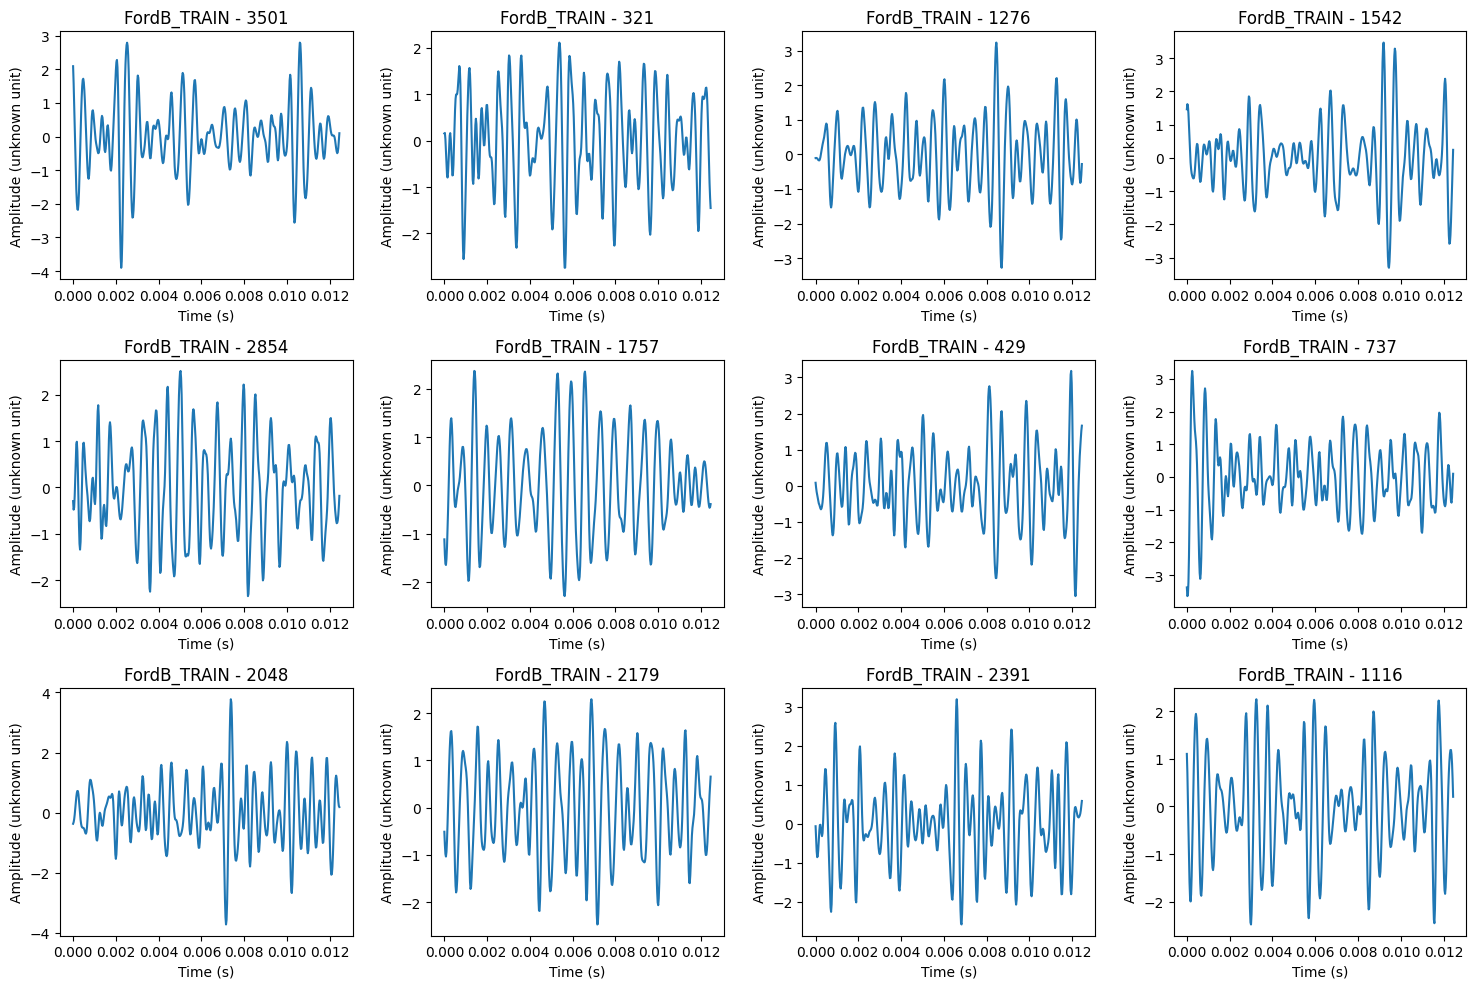

In [147]:
plot_datas(train_sample, sampling_frequency = sampling_frequency)


### 1.1.2 Test

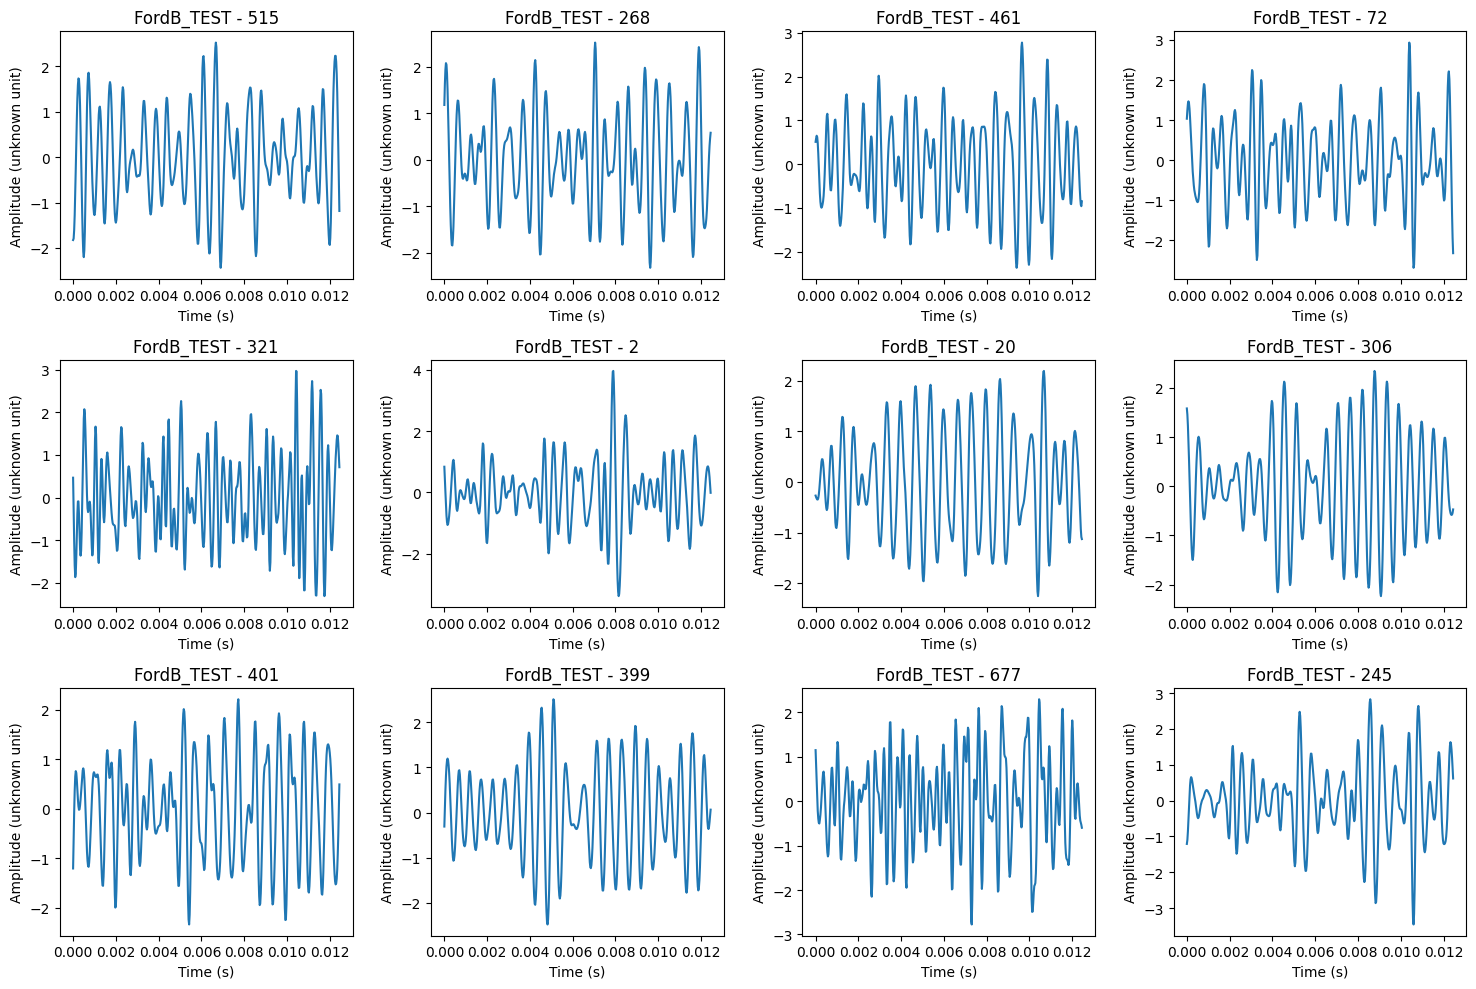

In [148]:
plot_datas(test_sample, sampling_frequency = sampling_frequency)

### 1.1.3 Analysis

- Some signals present an amplitude augmentation with the time where some other don't

- Some signals present some periodic patterns where some other don't


## 1.2 DFT Plots

## 1.2.0 Remarks

The sampling frequency is unknown which limits the interpretation of the spectrum-related-properties of the signals. However :
- the general pattern of the spectrum is not defined by this frequency. The sampling frequency only plays as a scaling of the frequency axis.
- each data is a sound of some automotive engines which commonly presents cyclical properties, hence the study of the spectrum is pertinent.

## 1.2.1 Codes and variables

Since the sampling frequency, it is arbitrarily set to 1

In [149]:
#sampling_frequency = 1
sampling_frequency = 40000

Code from Laurent Oudre's notebook

In [150]:
def my_fft(x,Fs):
    N=np.size(x)
    #Computation of the FFT
    X=np.fft.fft(x)
    X=np.fft.fftshift(X)
    # Computation the frequency vector
    f=np.fft.fftfreq(N, d=1/Fs)
    f=np.fft.fftshift(f)
    #return X[len(X)//2:],f[len(X)//2:]
    return X, f

Custom plot code

In [151]:

def plot_datas_dft(datas, Fs, x_decimal_number = 5, y_decimal_number = 0, plot_symetric_spectrum = True):
    plt.clf()

    # Calculate number of rows and columns (can be square or based on your preference)
    cols = math.ceil(math.sqrt(len(datas)))  # Try to make the figure roughly square
    rows = math.ceil(len(datas) / cols)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    # Flatten the axes array for easy iteration (only if more than 1 row/column)
    axes = axes.flatten()

    # Now plot something on each subplot
    for  i, data in enumerate(datas):

        # Display of the squared absolute value of the DFT as a function of frequency
        fft_data_values,f=my_fft(data.values,Fs)
        
        if not plot_symetric_spectrum:
            fft_data_values = fft_data_values[len(fft_data_values)//2 :]
            f = f[len(f)//2 :]

        axes[i].plot(f, np.abs(fft_data_values)**2)  # Replace with your actual plot logic
        axes[i].set_title(f'DFT {data.database_name} - {data.index}')
        axes[i].xaxis.set_major_formatter(mticker.FormatStrFormatter(f'%.{x_decimal_number}f'))  # x-axis
        axes[i].yaxis.set_major_formatter(mticker.FormatStrFormatter(f'%.{y_decimal_number}f'))  # y-axis
        axes[i].set_xlabel('log(f) ')
        axes[i].set_xscale('log')
        axes[i].set_ylabel('|X[k]|^2')



    # Hide unused subplots if any
    for i in range(len(datas), rows * cols):
        fig.delaxes(axes[i])  # Deletes the extra subplots

    plt.tight_layout()
    plt.show()

### 1.2.2 Train

<Figure size 640x480 with 0 Axes>

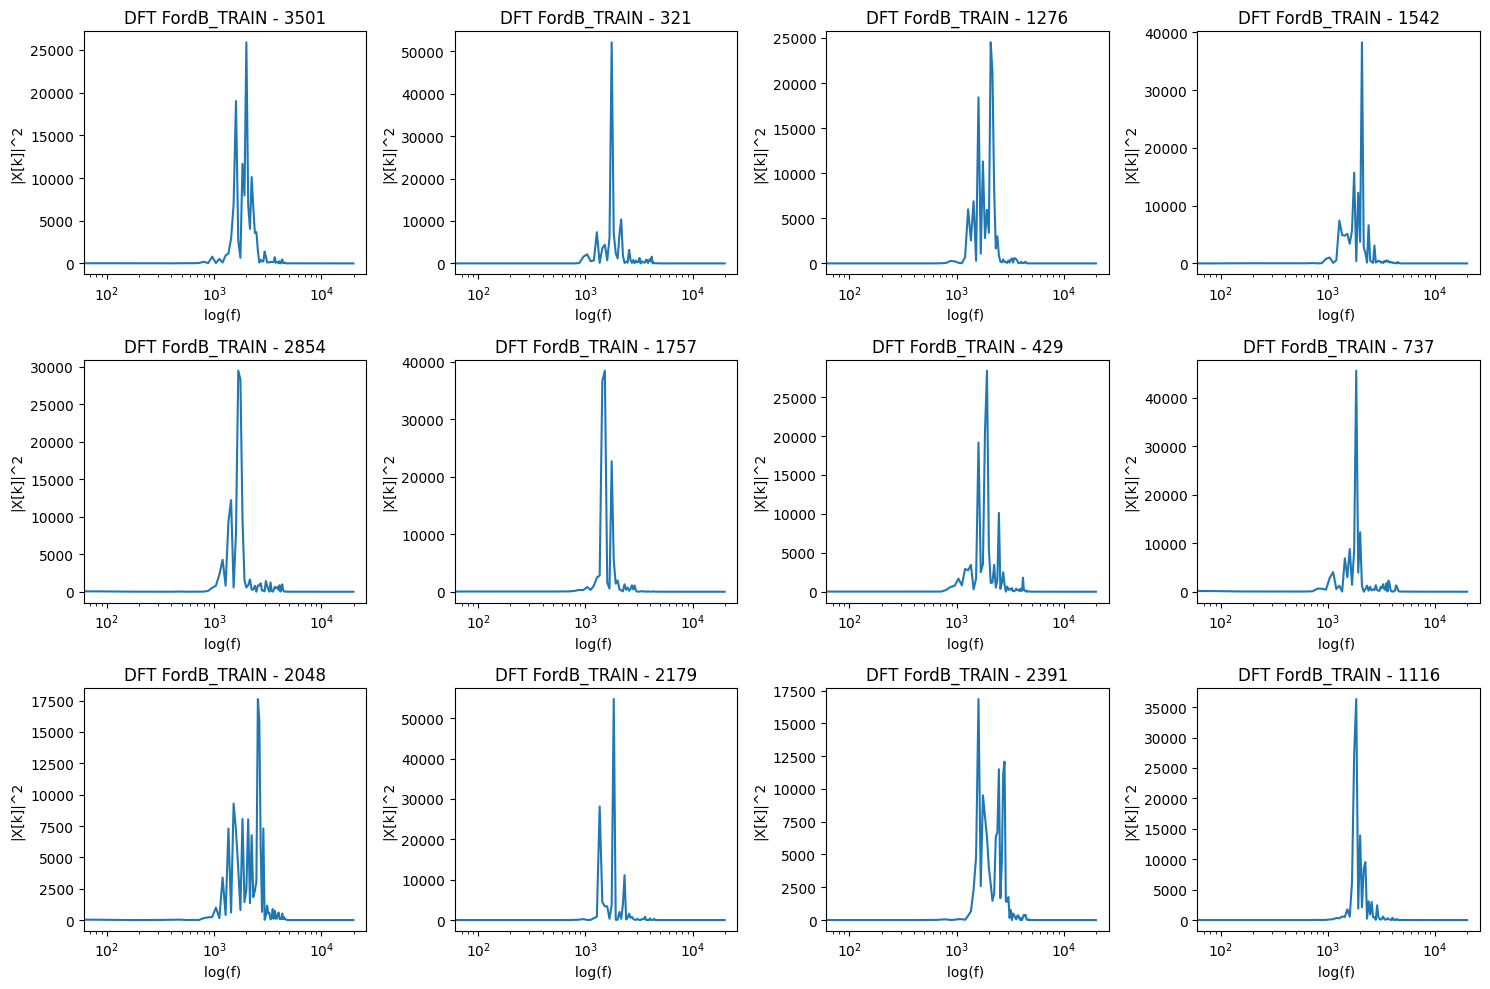

In [152]:
plot_datas_dft(train_sample, sampling_frequency)


<Figure size 640x480 with 0 Axes>

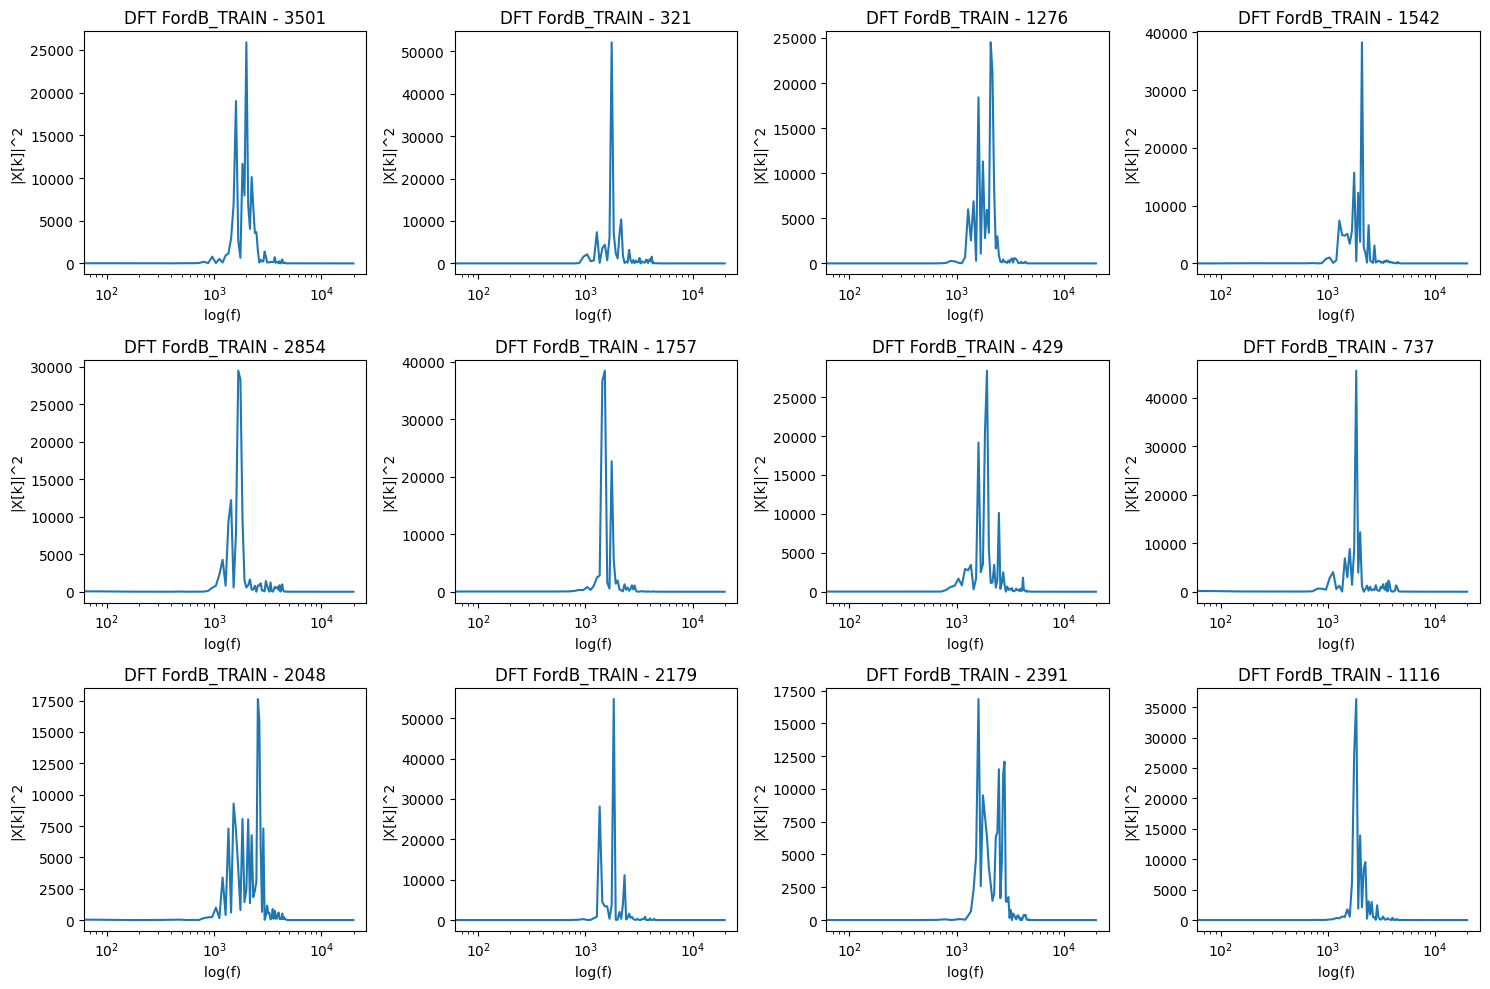

In [153]:
plot_datas_dft(train_sample, sampling_frequency, plot_symetric_spectrum = False)


### 1.2.3 Test

<Figure size 640x480 with 0 Axes>

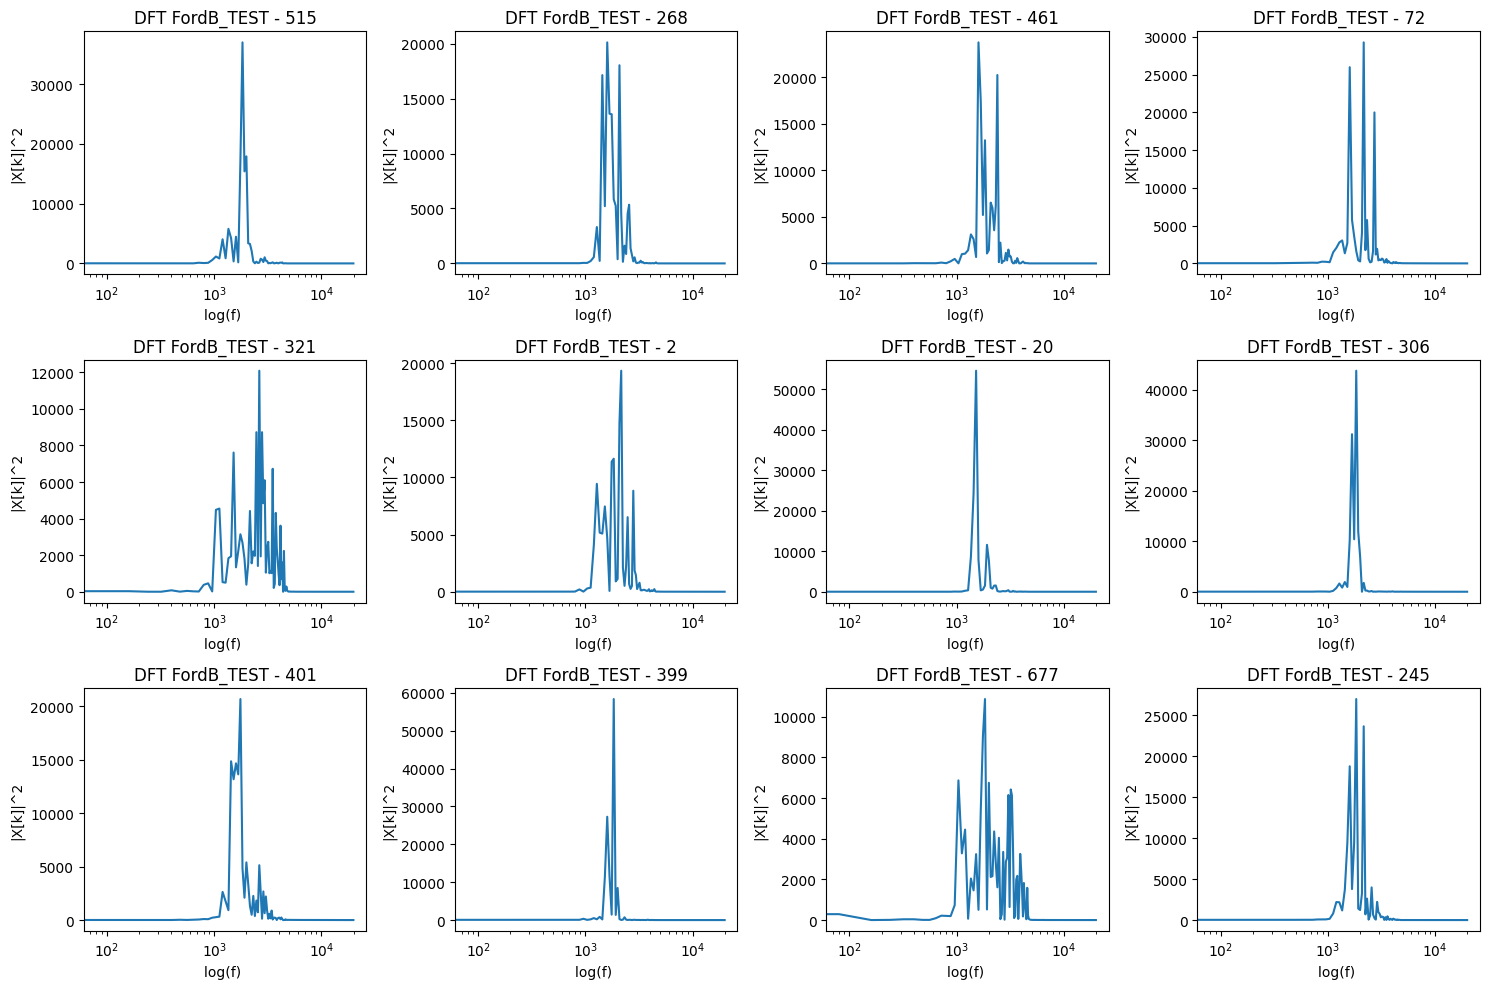

In [154]:
plot_datas_dft(test_sample, sampling_frequency)


<Figure size 640x480 with 0 Axes>

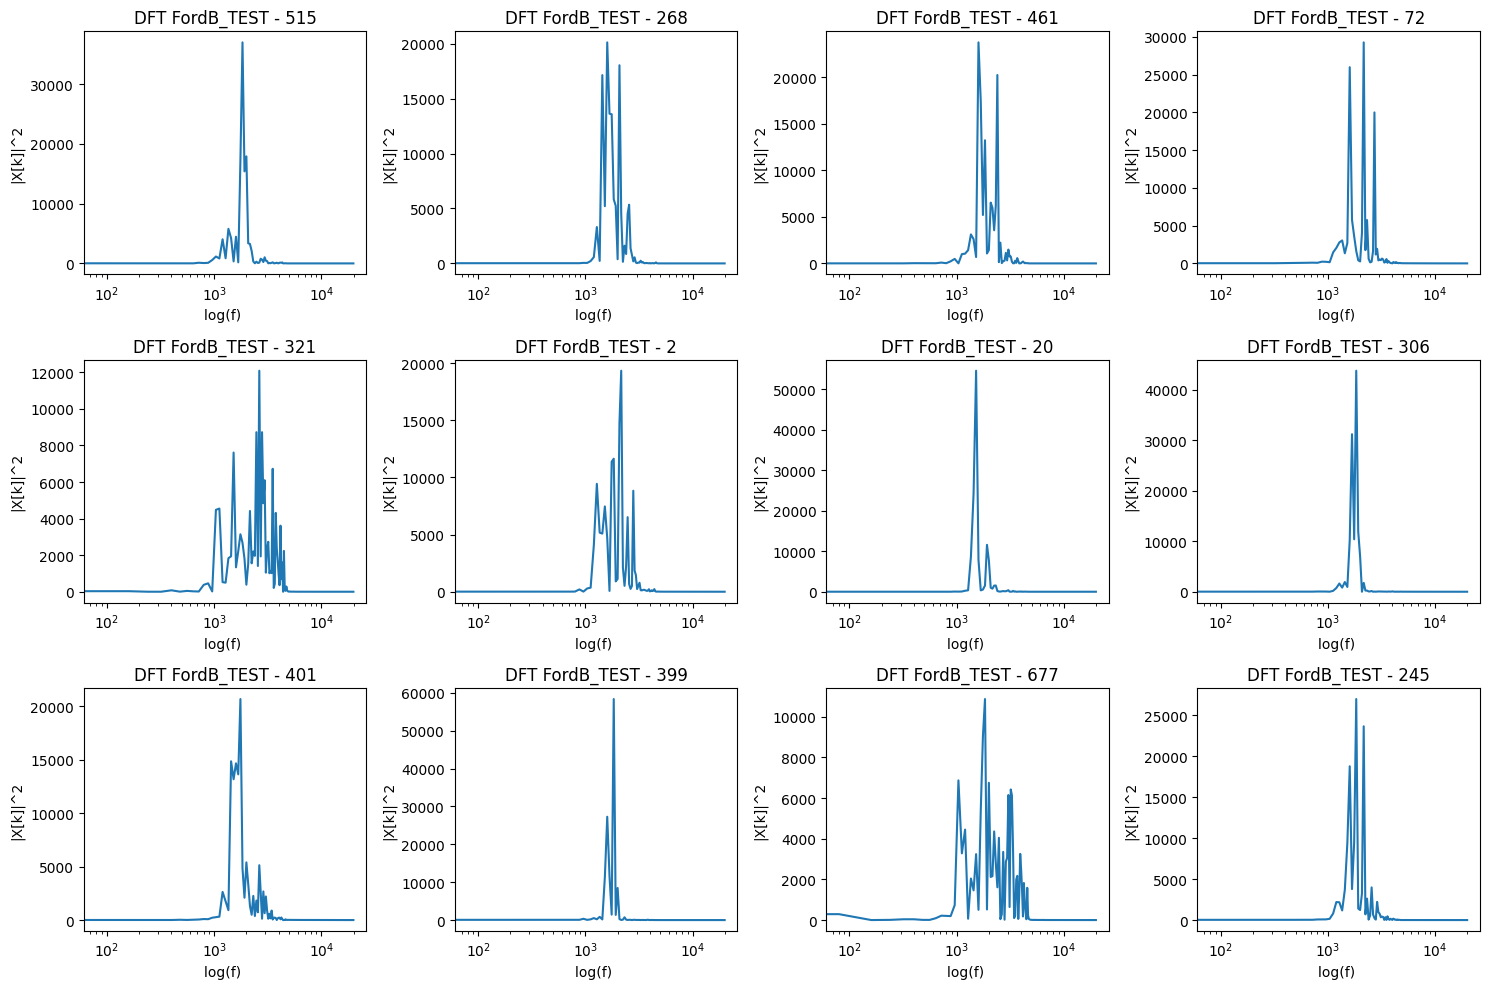

In [155]:
plot_datas_dft(test_sample, sampling_frequency, plot_symetric_spectrum = False)


### 1.2.4 Analysis

- The patterns are very similar with each other

- The frequency with the highest magnitude is likely to be the engine's rotation frequency

## 1.3 Autocorrelation Plots

### 1.3.1 Variables and codes

Code from Laurent Oudre's notebook

In [156]:
def autocorrelation(x,maxLags):
    N=len(x)
    gammax=np.correlate(x,x,'full')/N
    lags=np.arange(-maxLags,maxLags+1)
    gammax=gammax[N-maxLags-1:N+maxLags]
    return gammax,lags

Custom plot code

In [157]:
def plot_datas_autocorrelation(datas, maxLags, sampling_frequency = 1):
    plt.clf()


    # Calculate number of rows and columns (can be square or based on your preference)
    cols = math.ceil(math.sqrt(len(datas)))  # Try to make the figure roughly square
    rows = math.ceil(len(datas) / cols)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    # Flatten the axes array for easy iteration (only if more than 1 row/column)
    axes = axes.flatten()

    # Now plot something on each subplot
    for  i, data in enumerate(datas):

        gammax,lags = autocorrelation(data.values, maxLags)

        time_lags = lags / sampling_frequency
        

        axes[i].plot(time_lags, gammax)  # Replace with your actual plot logic
        axes[i].set_title(f'Biased autocorrelation {data.database_name} - {data.index}')
        axes[i].set_xlabel('lag (s)')
        axes[i].set_ylabel('$\gamma_x$ (unknown units)')


    # Hide unused subplots if any
    for i in range(len(datas), rows * cols):
        fig.delaxes(axes[i])  # Deletes the extra subplots

    plt.tight_layout()
    plt.show()

In [158]:
maxLags = 100

### 1.3.2 Train

<Figure size 640x480 with 0 Axes>

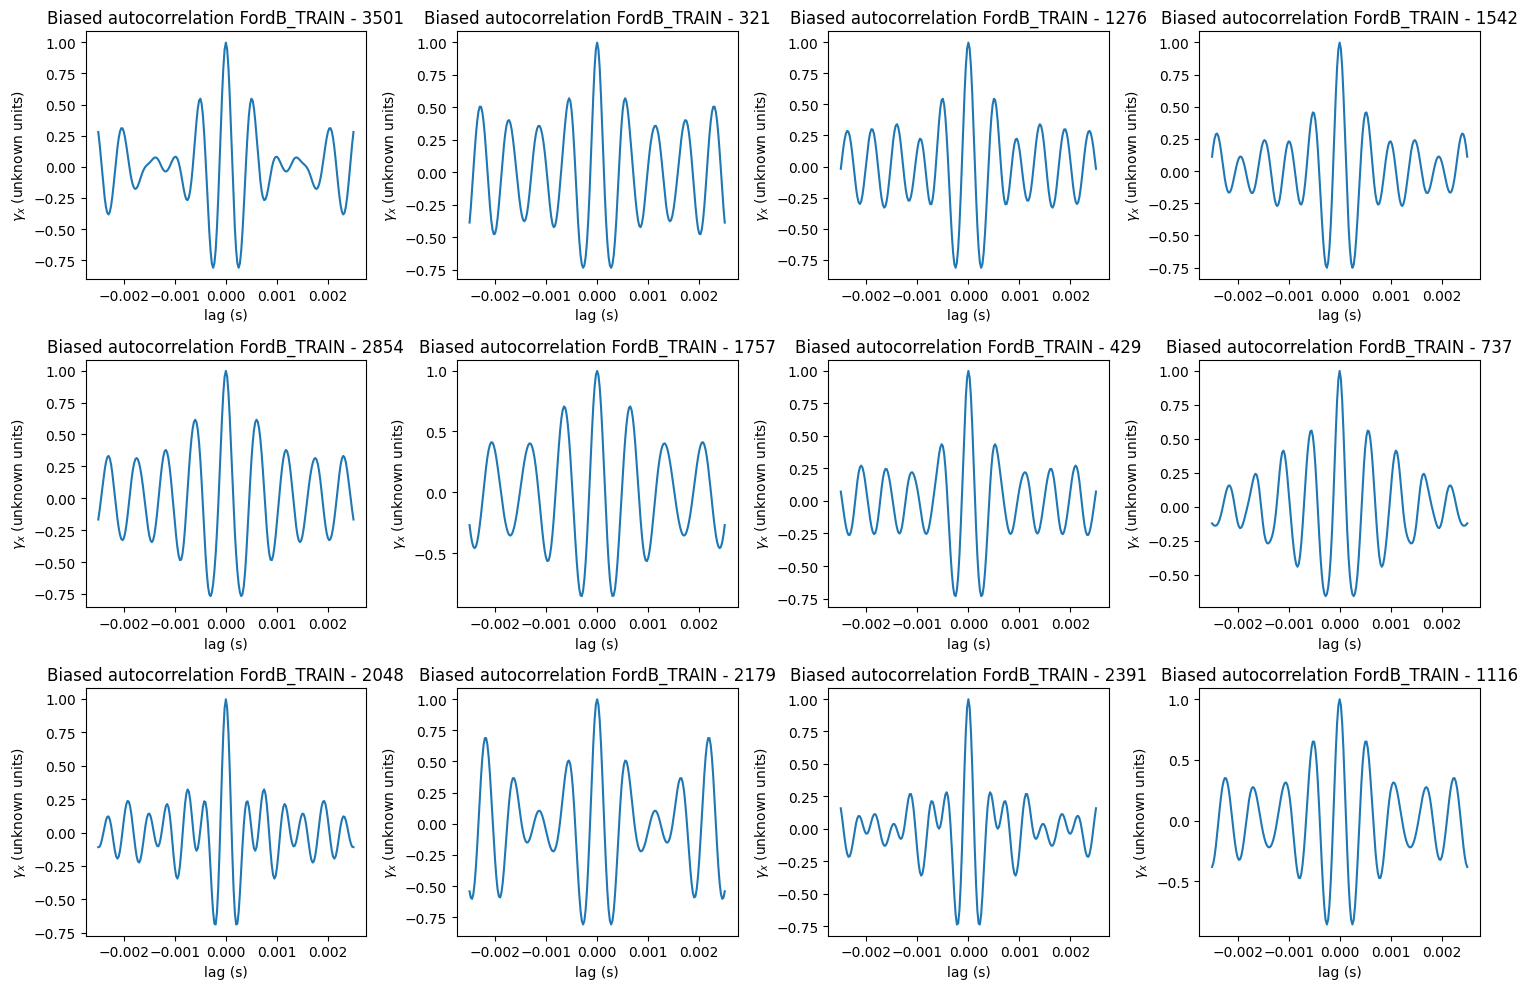

In [159]:
plot_datas_autocorrelation(train_sample, maxLags, sampling_frequency = sampling_frequency)

### 1.3.3 Test

<Figure size 640x480 with 0 Axes>

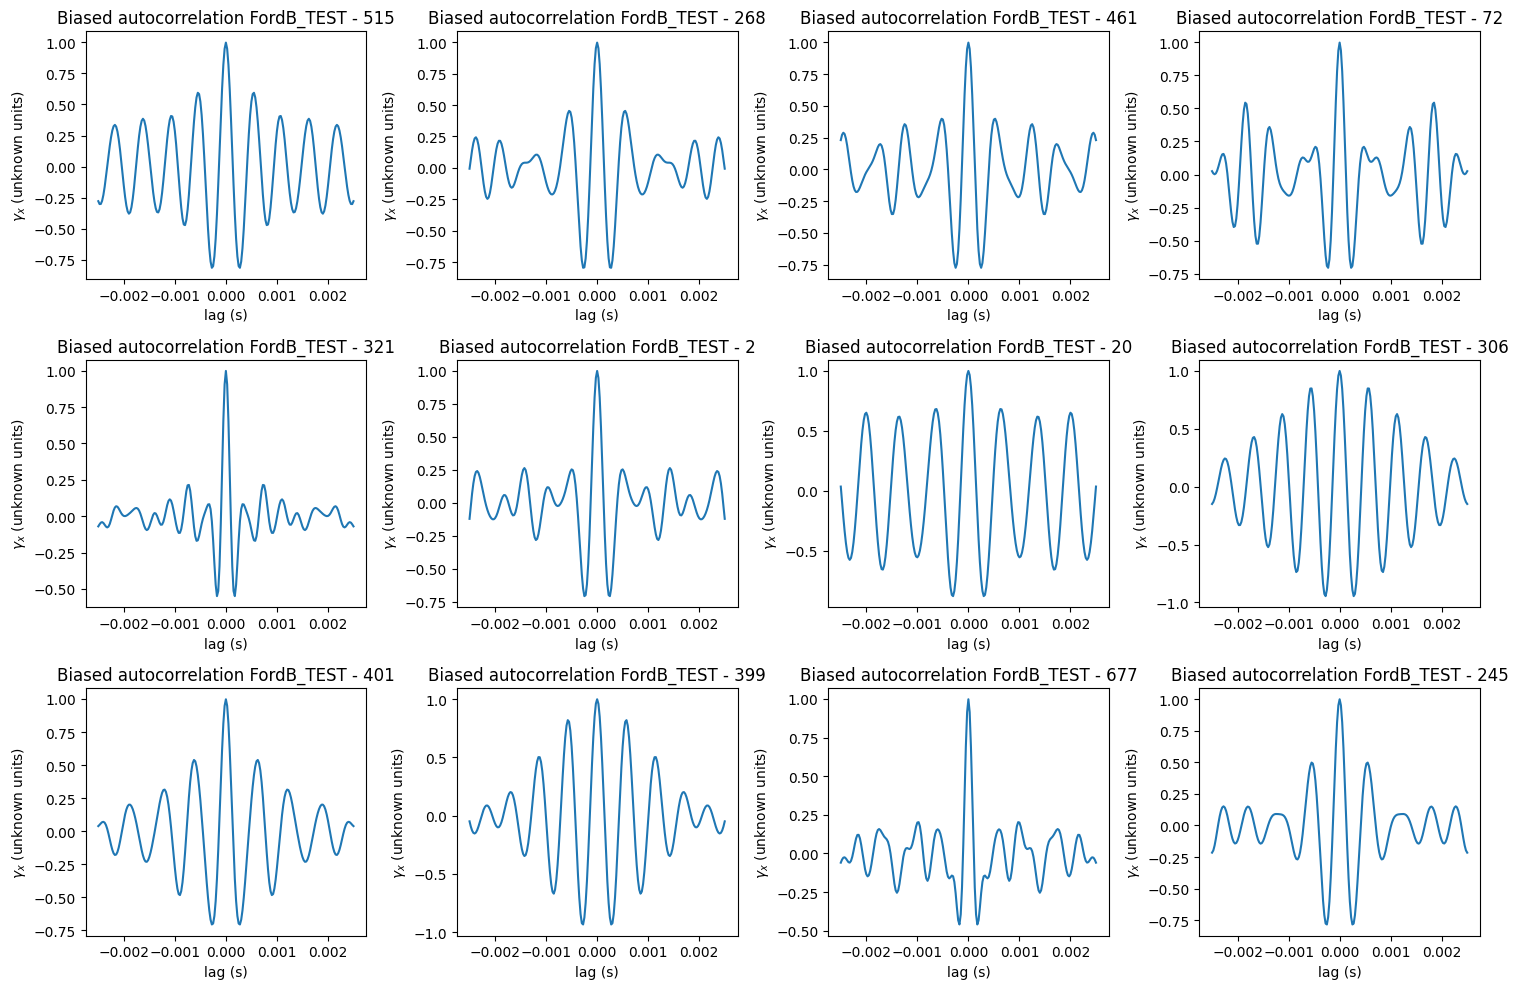

In [160]:
plot_datas_autocorrelation(test_sample, maxLags, sampling_frequency = sampling_frequency)

### 1.3.4 Analysis

- Two type of autocorrelation patterns seem to be present

- The regular autocorrelation plots might be a sign of an undamaged ungine as it highlights some clear cyclical properties

- The irregular seem to be sign of damaged engine as if the default was impacting the cyclical properties of the engine.

- Why wasn't this highlighted in the DFT plots ?
    - Maybe spectrum with larger frequency band are associated with damaged engines ?

## 1.4 Correlogram and Spectrogram Plots

### 1.4.1 Codes and variables

Codes from Laurent Oudre's notebook

In [161]:
def correlogram(x,Fs):
    gammax,lags=autocorrelation(x,len(x)-1)
    gammax=np.pad(gammax[len(x)-1:],(0, 1),mode='constant')
    #Computation of the FFT
    Gammax=np.fft.hfft(gammax)
    Gammax=np.fft.fftshift(Gammax)
    # Computation the frequency vector
    N=len(Gammax)
    f=np.fft.fftfreq(N, d=1/Fs)
    f=np.fft.fftshift(f)
    return Gammax,f

In [162]:
def periodogram(x,Fs):
    N=np.size(x)
    #Computation of the FFT
    X=np.fft.fft(x)
    X=np.fft.fftshift(X)
    Gammax=(np.abs(X)**2)/N
    # Computation the frequency vector
    f=np.fft.fftfreq(N, d=1/Fs)
    f=np.fft.fftshift(f)
    return Gammax,f   

Custom plot codes

In [163]:
def plot_correlogram(datas, Fs, x_decimal_number = 5, y_decimal_number = 0, plot_symetric_spectrum = True, xscale = None, yscale = None, normalise = True):
    plt.clf()

    # Calculate number of rows and columns (can be square or based on your preference)
    cols = math.ceil(math.sqrt(len(datas)))  # Try to make the figure roughly square
    rows = math.ceil(len(datas) / cols)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    # Flatten the axes array for easy iteration (only if more than 1 row/column)
    axes = axes.flatten()

    # Now plot something on each subplot
    for  i, data in enumerate(datas):

        Gammax, f = correlogram(data.values, Fs)
        
        if not plot_symetric_spectrum:
            Gammax = Gammax[len(Gammax)//2 :]
            f = f[len(f)//2 :]

        if normalise:
            Gammax = Gammax / np.max(Gammax)
            title_complement = 'normalised'

        axes[i].plot(f, Gammax)  # Replace with your actual plot logic
        axes[i].set_title(f'Correlogram {database.name} - {data.index} - {title_complement}')
        
        if xscale != None:
            axes[i].set_xscale(xscale)
        
        if yscale != None:
            axes[i].set_yscale(yscale)


    # Hide unused subplots if any
    for i in range(len(datas), rows * cols):
        fig.delaxes(axes[i])  # Deletes the extra subplots

    plt.tight_layout()
plt.show()

In [164]:
def plot_periodogram(datas, Fs, x_decimal_number = 5, y_decimal_number = 0, plot_symetric_spectrum = True, xscale = None, yscale = None, normalise = True):
    plt.clf()

    # Calculate number of rows and columns (can be square or based on your preference)
    cols = math.ceil(math.sqrt(len(datas)))  # Try to make the figure roughly square
    rows = math.ceil(len(datas) / cols)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    # Flatten the axes array for easy iteration (only if more than 1 row/column)
    axes = axes.flatten()

    # Now plot something on each subplot
    for  i, data in enumerate(datas):

        Gammax, f = periodogram(data.values, Fs)

       
        if not plot_symetric_spectrum:
            Gammax = Gammax[len(Gammax)//2 :]
            f = f[len(f)//2 :]

        if normalise:
            Gammax = Gammax / np.max(Gammax)
            title_complement = 'normalised'
        

        axes[i].plot(f, Gammax)  # Replace with your actual plot logic
        axes[i].set_title(f'Periodogram {data.database_name} - {data.index} - {title_complement}')
       
        if xscale != None:
            axes[i].set_xscale(xscale)
        
        if yscale != None:
            axes[i].set_yscale(yscale)


    # Hide unused subplots if any
    for i in range(len(datas), rows * cols):
        fig.delaxes(axes[i])  # Deletes the extra subplots

    plt.tight_layout()
    plt.show()

### 1.4.2 Train

<Figure size 640x480 with 0 Axes>

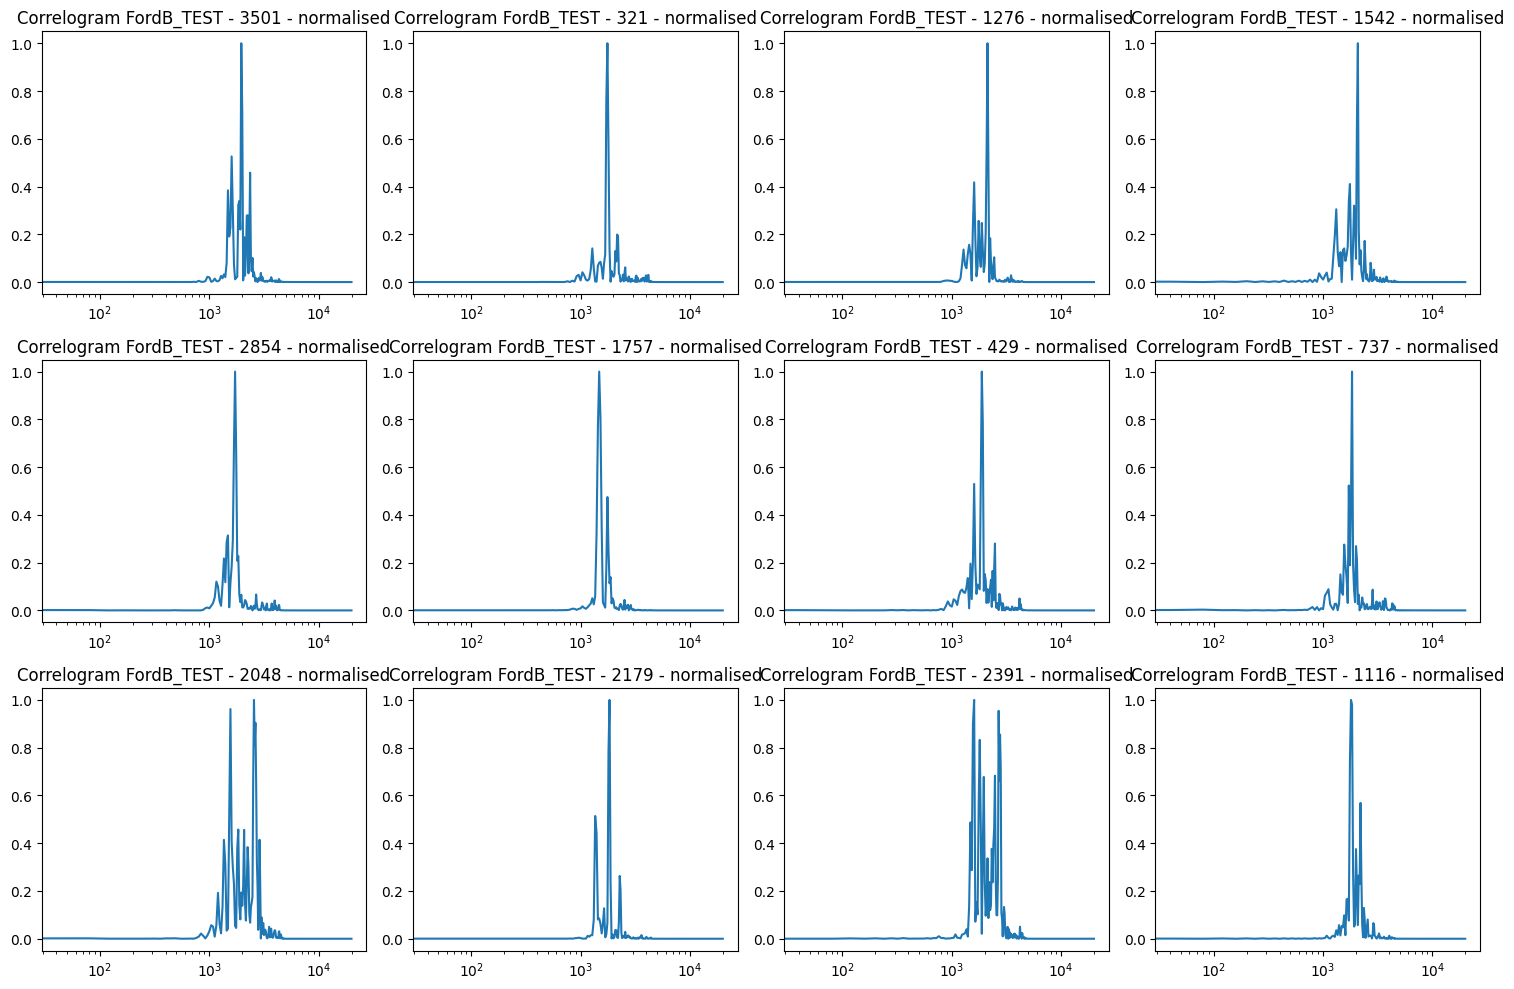

In [165]:
#plot_correlogram(train_sample, sampling_frequency, plot_symetric_spectrum = False, xscale = 'log', yscale = 'log')
plot_correlogram(train_sample, sampling_frequency, plot_symetric_spectrum = False, xscale = 'log')

<Figure size 640x480 with 0 Axes>

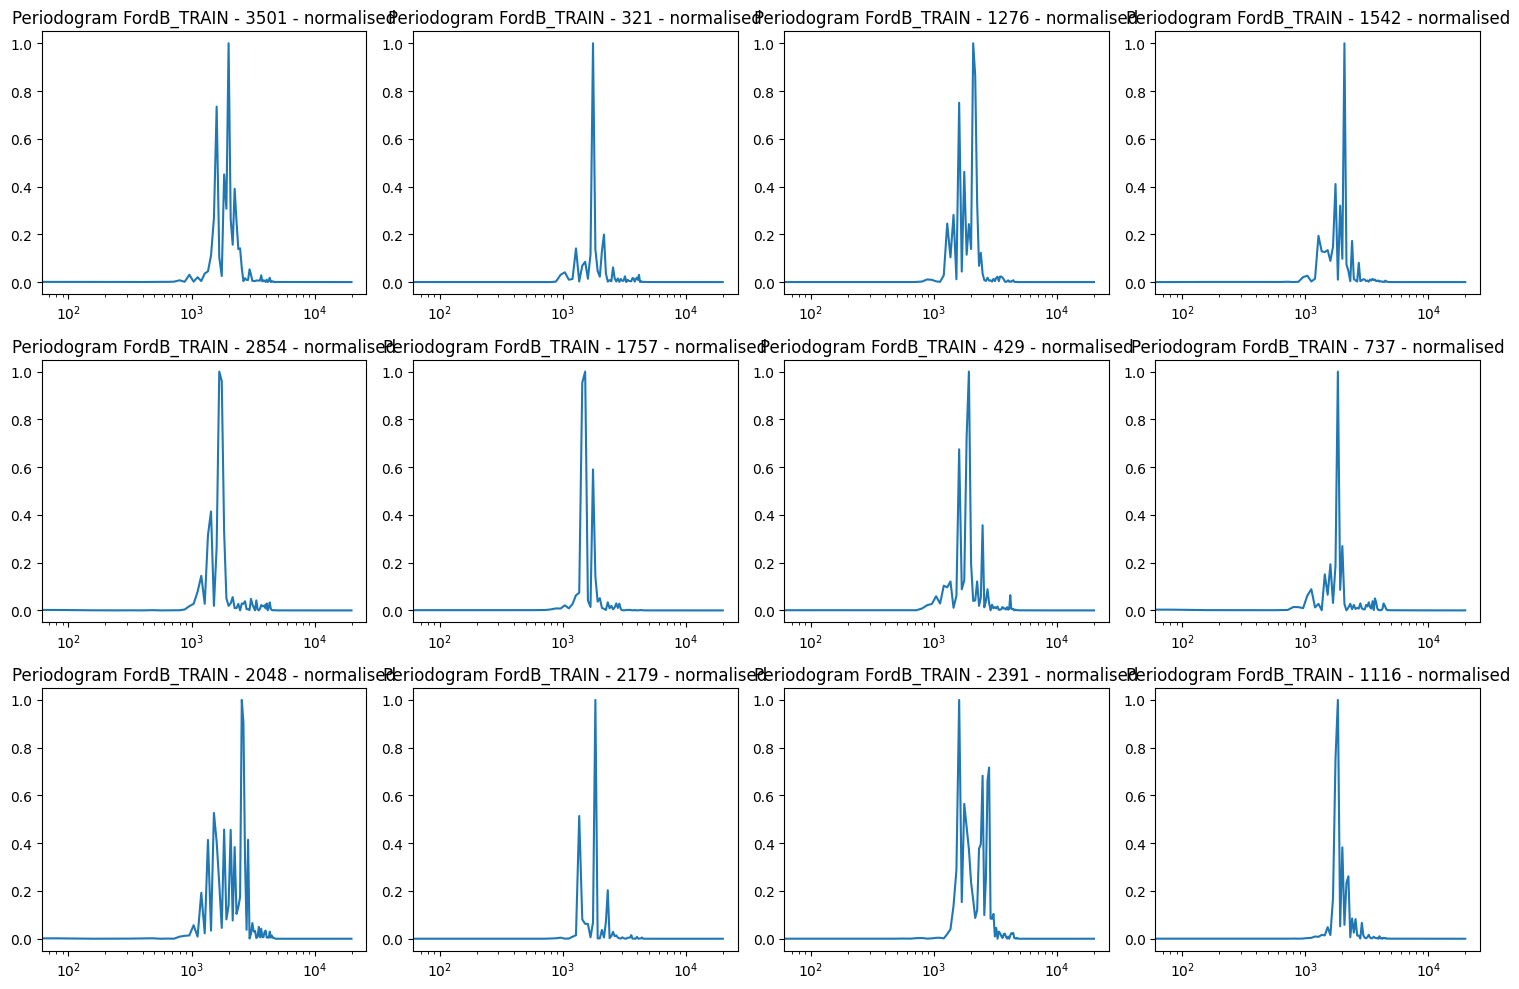

In [187]:
plot_periodogram(train_sample, sampling_frequency, plot_symetric_spectrum = False, xscale = 'log')

### 1.4.3 Test

<Figure size 640x480 with 0 Axes>

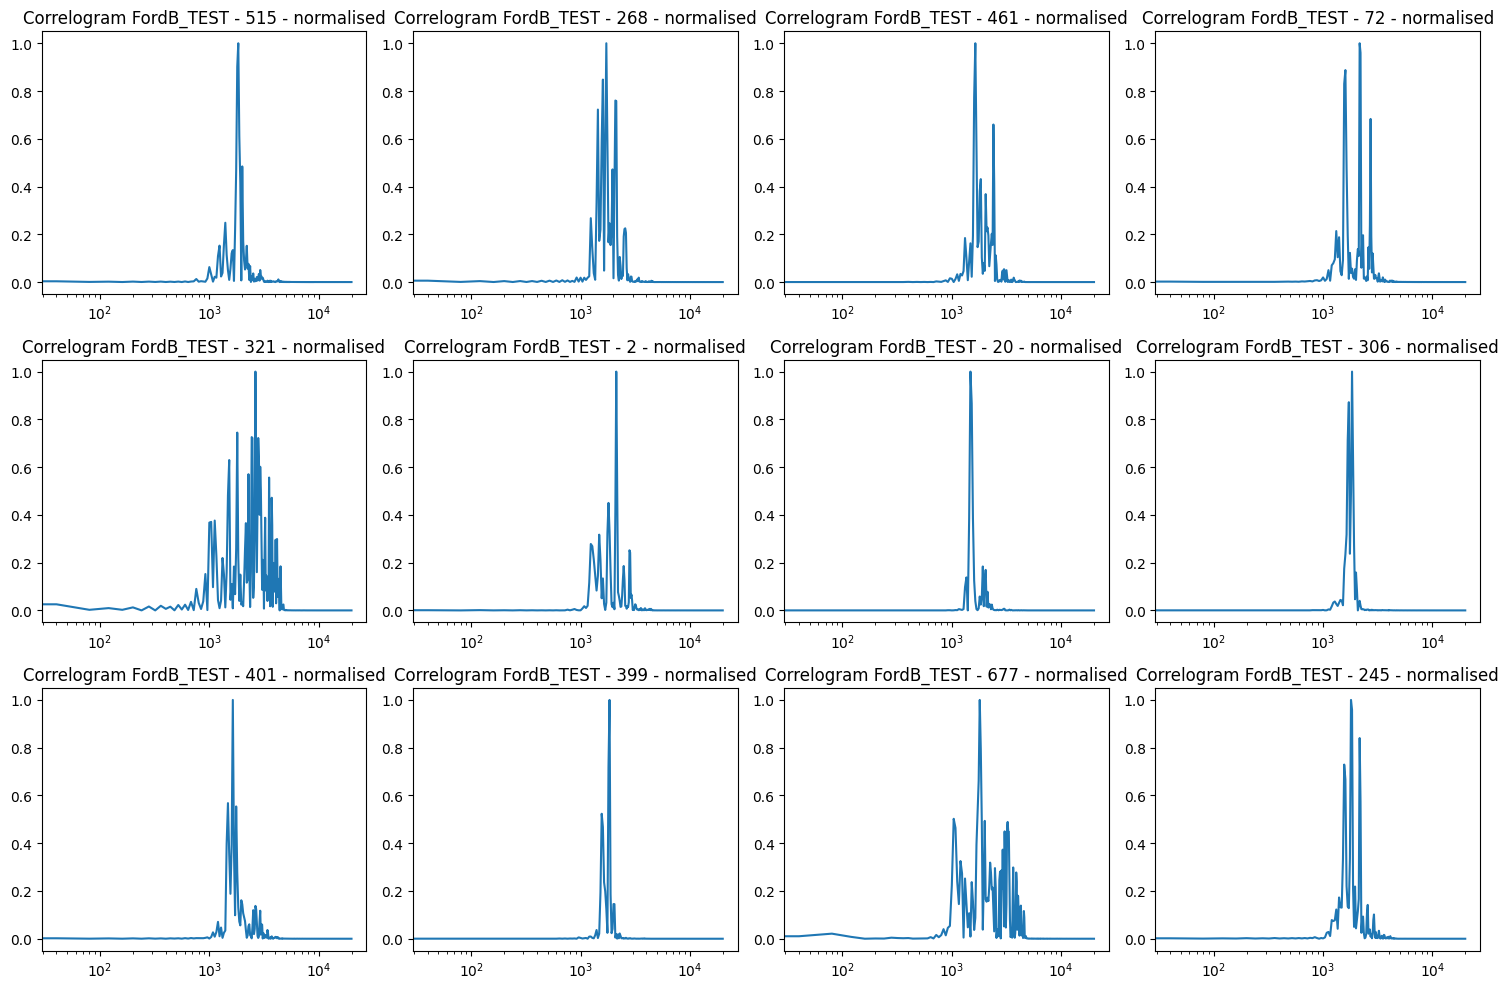

In [167]:
plot_correlogram(test_sample, sampling_frequency, plot_symetric_spectrum = False, xscale = 'log')

<Figure size 640x480 with 0 Axes>

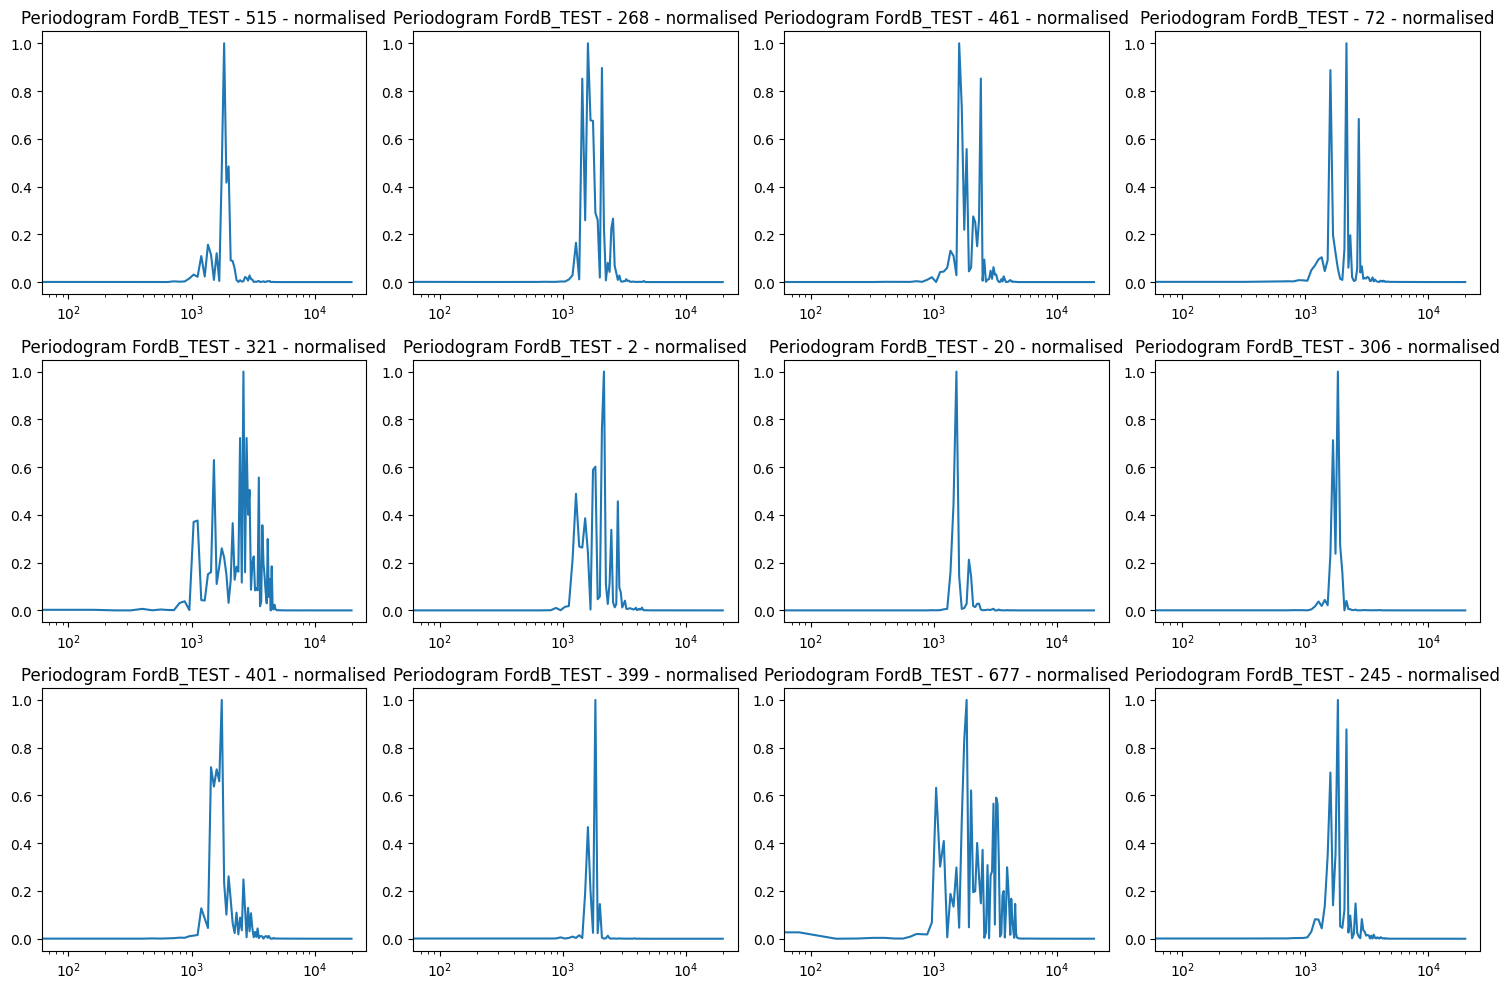

In [168]:
plot_periodogram(test_sample, sampling_frequency, plot_symetric_spectrum = False, xscale = 'log')

### 1.4.4. Analysis

The width of the emission band seems larger from some signal. It could indicate the presence of an additionnal noise source, like the sound of a default.

## 1.5 Spectrogram Plots

### 1.5.1 Codes and variables

Code from Laurent Oudre's Notebook

In [169]:
def my_spectrogram(x,Nw,No,Fs):
    f, t, Sxx = signal.stft(x, fs=Fs,nperseg=Nw, noverlap=No, nfft=4*Nw)
    return f,t,Sxx

Custom plot code

In [170]:
def plot_spectrogram(datas, time_window_length, overlap_length, Fs, normalise = 'overall'):
    plt.clf()

    # Calculate number of rows and columns (can be square or based on your preference)
    cols = math.ceil(math.sqrt(len(datas)))  # Try to make the figure roughly square
    rows = math.ceil(len(datas) / cols)

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

    # Flatten the axes array for easy iteration (only if more than 1 row/column)
    axes = axes.flatten()

    # Now plot something on each subplot
    for  i, data in enumerate(datas):

        f,t,Sxx = my_spectrogram(data.values, time_window_length, overlap_length, Fs)
        abs_Sxx = np.abs(Sxx)**2
        if normalise == 'overall':
            
            abs_Sxx = abs_Sxx/np.max(abs_Sxx)
        
        elif normalise == 'column_wise':
            for j in range(len(Sxx[0])):
                abs_Sxx[:,j] = abs_Sxx[:,j]/np.max(abs_Sxx[:,j])

        im = axes[i].pcolormesh(t,f,abs_Sxx, shading='auto') # Replace with your actual plot logic
        fig.colorbar(im, ax=axes[i])
        axes[i].set_title(f'Spectrogram {data.database_name} {data.index}')
        axes[i].set_xlabel('time (s)')
        axes[i].set_ylabel('frequency (Hz)')


    # Hide unused subplots if any
    for i in range(len(datas), rows * cols):
        fig.delaxes(axes[i])  # Deletes the extra subplots

    plt.tight_layout()
    plt.show()

In [171]:
time_window_length = 30
overlap_length = 10

### 1.5.2 Train

<Figure size 640x480 with 0 Axes>

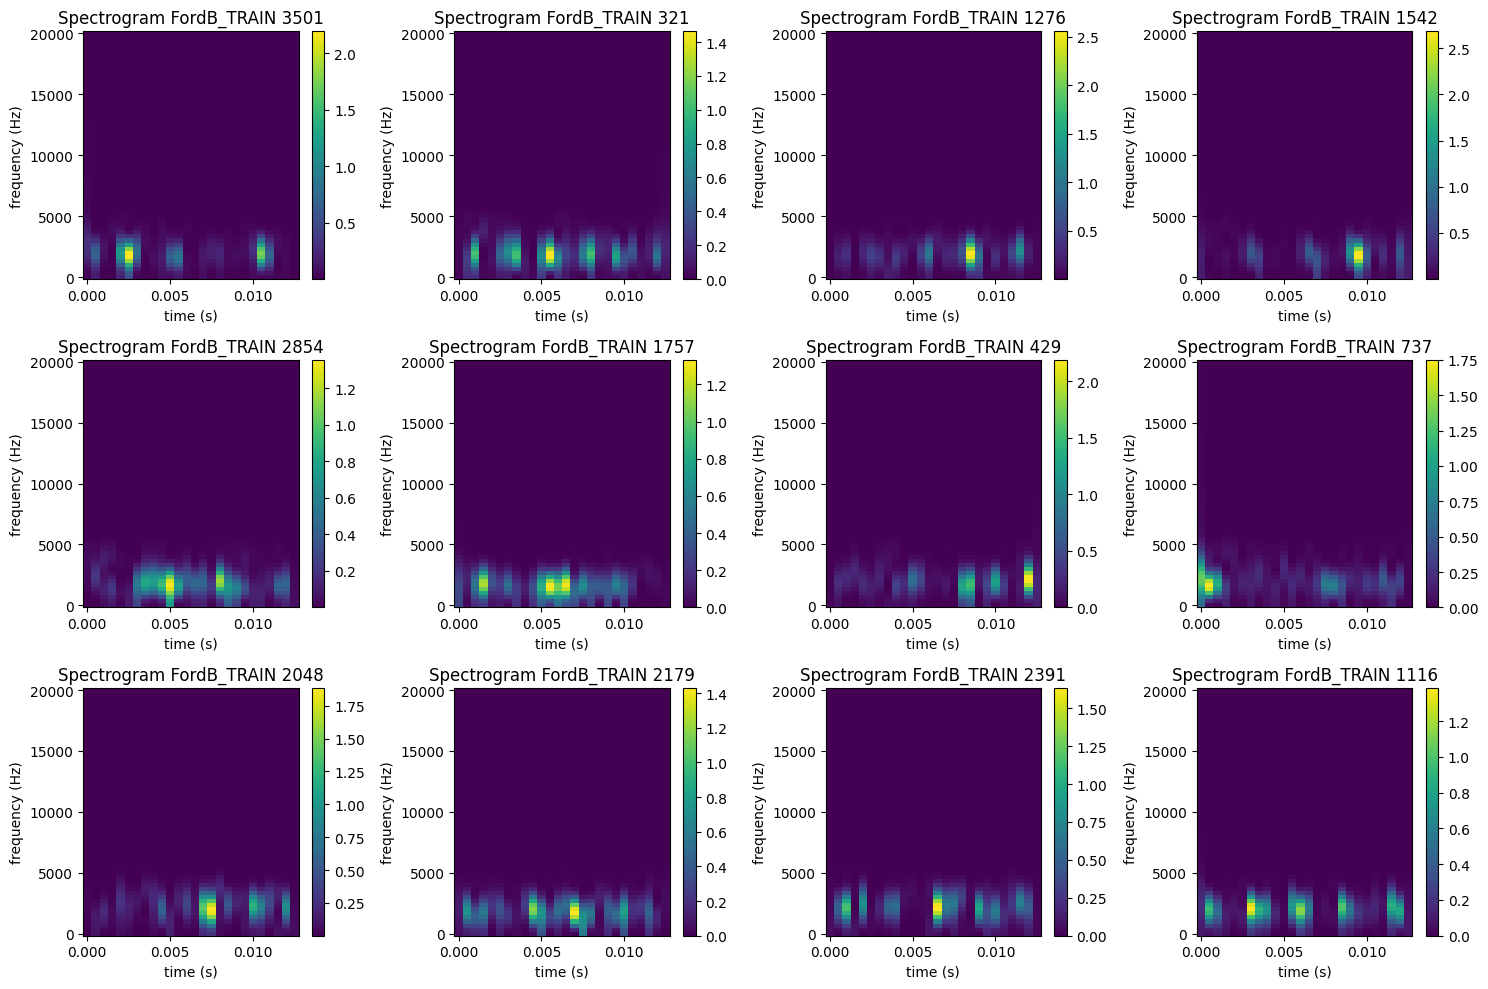

In [189]:
plot_spectrogram(train_sample, time_window_length, overlap_length, sampling_frequency, normalise = 'False')

### 1.5.3 Test

<Figure size 640x480 with 0 Axes>

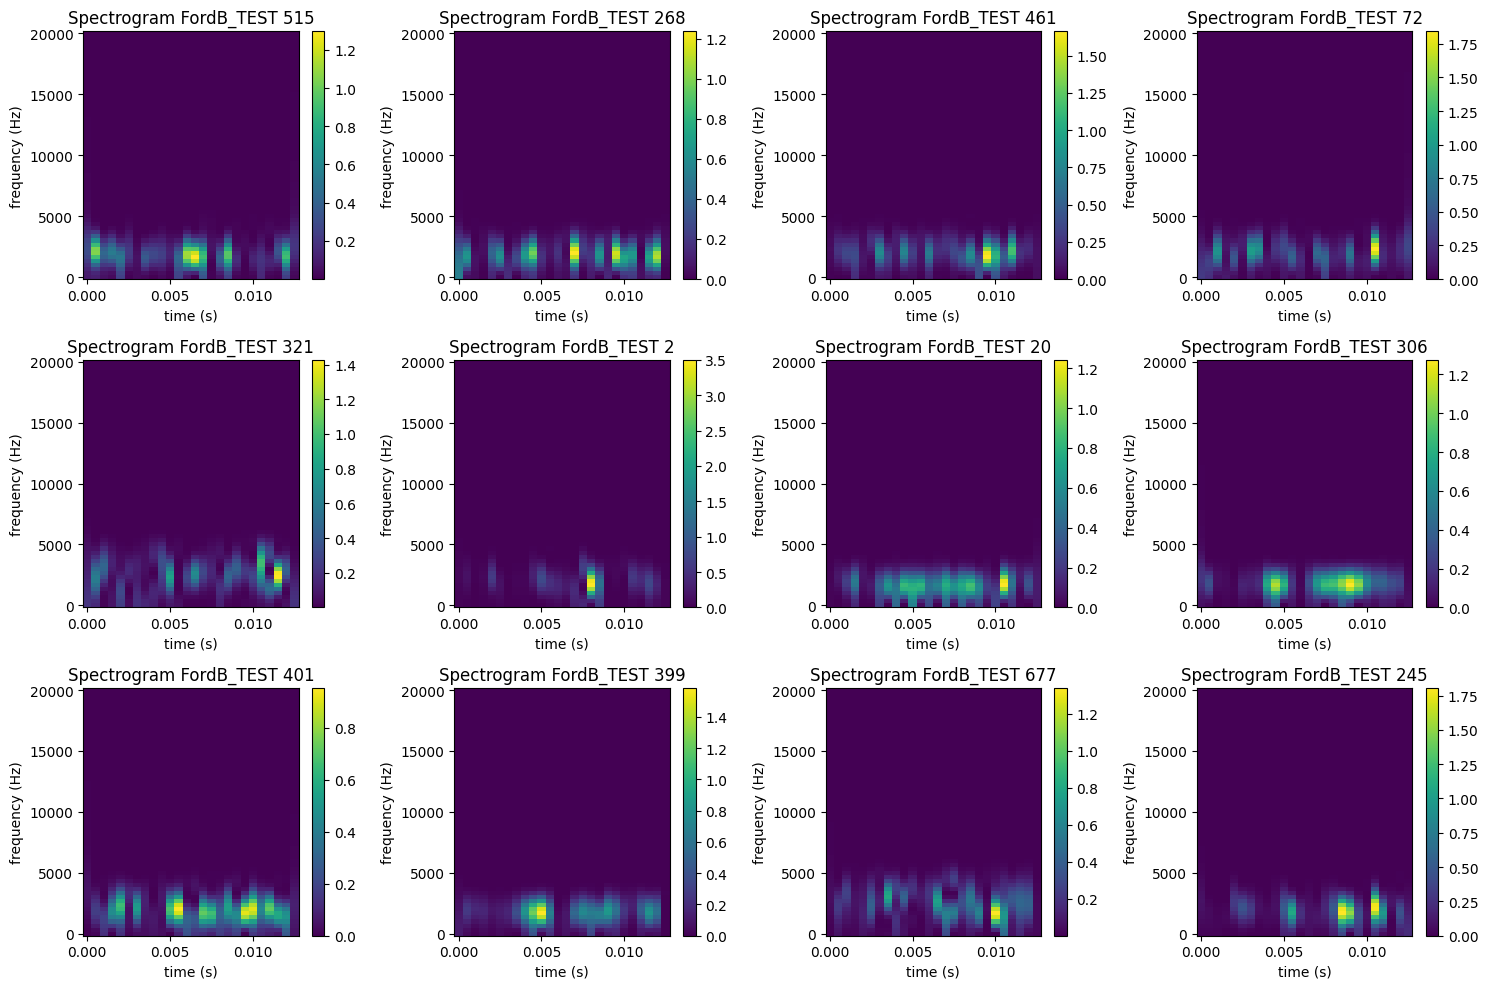

In [186]:
plot_spectrogram(test_sample, time_window_length, overlap_length, sampling_frequency, normalise = 'False')

### 1.5.4. Analysis

The spectrograms shows that there could be some different emission regimes inside of a same signal. Hence a segmentation analysis could be interesting to seperate the regimes and maybe find some links between some particular regimes and the presence of defaults.

# 2. Further analysis

## 2.1. Turning the database into audio files

In [174]:
class Database_with_audio(Database):
    def __init__(self, database, audio_folder, sample_rate):
        super().__init__(database.name, database.datas)
        self.audio_folder = audio_folder
        self.sample_rate = sample_rate

        self.audio_datas = []
        for data in self.datas:
            self.audio_datas.append(Data_with_audio(data, self.audio_folder, self.sample_rate))


        

In [175]:
class Data_with_audio(Data):
    def __init__(self, data, audio_folder, sample_rate):
        super().__init__(data.index, data.values, data.database_name)
        self.audio_file_path = os.path.join(audio_folder, f'{data.database_name}_{data.index}.wav')
        self.sample_rate = sample_rate

        int_16_bit_range = 32767

        self.values = np.array(self.values)
        self.values = int_16_bit_range*self.values/np.max(self.values)
        self.values = self.values.astype(np.int16)
        audio = self.values
        for i in range(100):
            audio = np.concatenate((audio, self.values))
        wavfile.write(self.audio_file_path, self.sample_rate, audio)




In [176]:
train_audio_folder = '/teamspace/studios/this_studio/Ford_audio/Train'
train_database_with_audio = Database_with_audio(train_database, train_audio_folder, sample_rate = sampling_frequency)

test_audio_folder = '/teamspace/studios/this_studio/Ford_audio/Test'
test_database_with_audio = Database_with_audio(test_database, test_audio_folder, sample_rate = sampling_frequency)

In [177]:
test_database_with_audio.audio_datas[0].values

array([ -1407,  -1853,  -1822,  -1252,   -144,   1169,   2526,   3744,
         4820,   5817,   6756,   7459,   7678,   7170,   5732,   3184,
         -435,  -4843,  -9396, -13447, -16407, -17677, -17039, -14457,
       -10164,  -4675,   1428,   7532,  12947,  17062,  19400,  19740,
        18124,  14703,   9865,   4190,  -1520,  -6703, -10707, -13184,
       -13955, -13180, -11220,  -8657,  -6017,  -3794,  -2272,  -1386,
        -1037,   -919,   -552,    249,   1464,   2983,   4564,   6042,
         7279,   8035,   8263,   7852,   6830,   5207,   3031,    399,
        -2344,  -4823,  -6629,  -7458,  -7292,  -6276,  -4658,  -3074,
        -1935,  -1384,  -1433,  -1858,  -2293,  -2414,  -1938,   -960,
          365,   1768,   3033,   3963,   4381,   4413,   4026,   3270,
         2087,    572,  -1112,  -2867,  -4313,  -5102,  -5075,  -4207,
        -2823,  -1428,   -506,   -351,   -795,  -1344,  -1419,   -513,
         1564,   4533,   7687,  10168,  11213,  10502,   7946,   4008,
      

### 2.2 Analysis

The signals are way to short to be listened to, hence an analysis by ear is impossible.

# 3. Shannon Entropy distribution

In [190]:
def shannon_entropy(x):
    X,f = my_fft(x,1)
    normalised_X = (np.abs(X)**2)/np.sum(np.abs(X)**2)
    H = -np.sum(normalised_X*np.log(normalised_X))
    return H


    

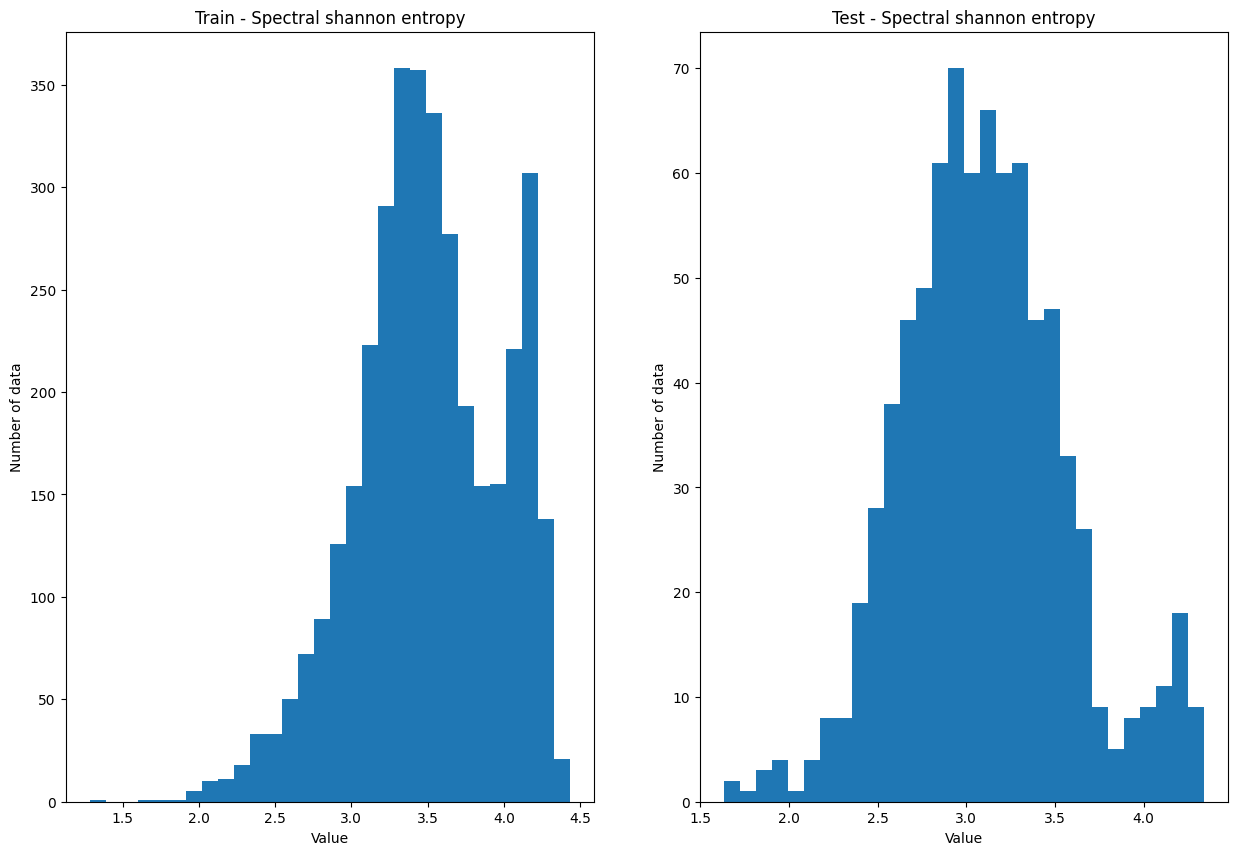

In [191]:
train_shannon_entropy = [shannon_entropy(data.values) for data in train_database.datas ]
test_shannon_entropy = [shannon_entropy(data.values) for data in test_database.datas ]


cols = math.ceil(math.sqrt(2))  # Try to make the figure roughly square
rows = math.ceil(2 / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))

# Flatten the axes array for easy iteration (only if more than 1 row/column)
axes = axes.flatten()

axes[0].hist(train_shannon_entropy, bins = 30)
axes[0].set_title(f'Train - Spectral shannon entropy')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Number of data')

axes[1].hist(test_shannon_entropy, bins = 30)
axes[1].set_title(f'Test - Spectral shannon entropy')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Number of data')


plt.show()

### 3.2. Analysis

Two pics seem to be present in each entropy distribution. Hence it can reasonably assume that Shannon's entropy can be used to highlight the presence of a default. The addition of a default noise source to a motor noise source should increase the information in the signal, thus the pic with the higher shannon entropy should be associated with defectuous motors.